In [1]:
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn import svm

In [2]:
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
img = mpimg.imread('./data/non-vehicles/GTI/image1470.png')
# img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

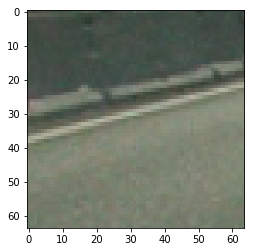

In [6]:
plt.imshow(img)

In [5]:
from skimage.feature import hog

from sklearn.preprocessing import StandardScaler


pix_per_cell = 8
cell_per_block = 2
orient = 9

features, hog_image = hog(img, orientations=orient, 
                          pixels_per_cell=(pix_per_cell, pix_per_cell), 
                          cells_per_block=(cell_per_block, cell_per_block), 
                          visualise=True, feature_vector=False)

/home/jeph/CarND-Vehicle-Detection/env/local/lib/python2.7/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


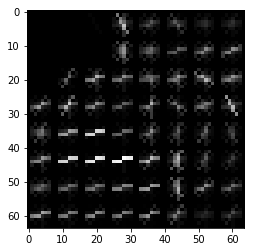

In [6]:
plt.imshow(hog_image, cmap='gray')

In [7]:
import os

def load_images(dirpath):
    imgs = []
    for root, _, filenames in os.walk(dirpath):
        for name in filenames:
            if not name.endswith(('.jpg', '.png')):
                continue
            filepath = os.path.join(root, name)
            img = mpimg.imread(filepath)
            imgs.append(img)
    return imgs

In [8]:
vehicles = load_images('./data/vehicles/')

In [9]:
non_vehicles = load_images('./data/non-vehicles/')

In [15]:
print(len(vehicles))
print(len(non_vehicles))

8792
8968


In [10]:
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


def extract_features(imgs, *args, **kwargs):
    return [extract_feature(img, *args, **kwargs) for img in imgs]



def extract_feature(img, cspace='YCrCb', spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), pix_per_cell=8, cell_per_block=2, 
                    orient=9, hog_channel='ALL'):
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: 
        feature_image = np.copy(img)      

    spatial_features = bin_spatial(feature_image, size=spatial_size)
    hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
    
    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(img.shape[2]):
            hog_features.append(hog(img[:,:,channel], orientations=orient, 
                      pixels_per_cell=(pix_per_cell, pix_per_cell), 
                      cells_per_block=(cell_per_block, cell_per_block), 
                      visualise=False, feature_vector=True))
        hog_features = np.ravel(hog_features)
    else:
        hog_features = hog(img[:,:,hog_channel], orientations=orient, 
                      pixels_per_cell=(pix_per_cell, pix_per_cell), 
                      cells_per_block=(cell_per_block, cell_per_block), 
                      visualise=False, feature_vector=True)

    features = np.concatenate((spatial_features, hist_features, hog_features))
    return features

In [11]:
vehicles[0].shape

(64, 64, 3)

In [12]:
extract_features(vehicles[:2])[0].shape

(8460,)

In [13]:
vehicle_features = extract_features(vehicles)

In [14]:
nonvehicle_features = extract_features(non_vehicles)

In [15]:
X = np.vstack((vehicle_features, nonvehicle_features)).astype(np.float64)
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

In [16]:
y = np.hstack((np.ones(len(vehicle_features)), 
              np.zeros(len(nonvehicle_features))))

In [17]:
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2)

In [18]:
svc = svm.LinearSVC(C=0.1)

In [19]:
svc.fit(X_train, y_train)

LinearSVC(C=0.1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [20]:
print('Test Accuracy:', svc.score(X_test, y_test))

('Test Accuracy:', 0.97972972972972971)


In [21]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [22]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
    

In [23]:
img = mpimg.imread('./test_images/test1.jpg')

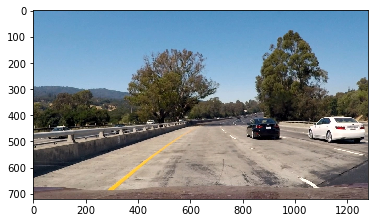

In [24]:
plt.imshow(img)

In [25]:
windows = slide_window(img, xy_window=(128,128), xy_overlap=(0.25, 0.25))

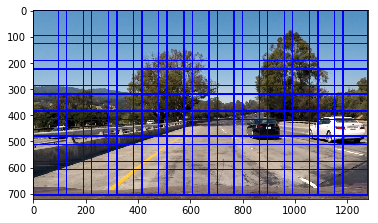

In [26]:
plt.imshow(draw_boxes(img, windows, thick=3))

In [44]:
def generate_all_windows(img, overlap=0.75):
    windows = []
    
    windows += slide_window(img, x_start_stop=[704, None], 
                            y_start_stop=[375, 439], xy_window=(int(96*1.25), 96), 
                            xy_overlap=(overlap, overlap))
    windows += slide_window(img, x_start_stop=[768, None], 
                            y_start_stop=[375, 567], xy_window=(int(96*1.25), 96), 
                            xy_overlap=(overlap*0.9, overlap*0.9))
    windows += slide_window(img, x_start_stop=[768, None], 
                            y_start_stop=[375, 695], xy_window=(int(224*1.25), 224), 
                            xy_overlap=(overlap*1., overlap*1.))
    return windows


def search_windows(img, windows, scaler, svc):
    X_test = []
    for window in windows:
        # TODO: make this more readable
        img_window = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        features = extract_feature(img_window, cspace='RGB')
        X_test.append(features)

    predict = svc.predict(scaler.transform(np.array(X_test)))
    
    hot_windows = []
    for i, pred in enumerate(predict):
        if pred == 1.:
            hot_windows.append(windows[i])
    return hot_windows
    

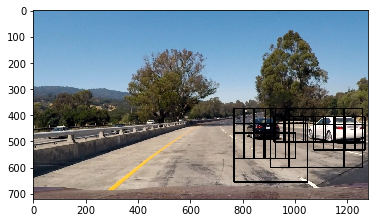

In [71]:
img = mpimg.imread('./test_images/test1.jpg') / 255.
windows = generate_all_windows(img)
# windows = slide_window(img)
hot_windows = search_windows(img, windows, X_scaler, svc)
plt.imshow(draw_boxes(img, hot_windows, thick=4))

In [72]:
img.shape

(720, 1280, 3)

In [73]:
extract_feature(img / 255., cspace='RGB')

array([ 0.00152057,  0.00231449,  0.00303729, ...,  0.01634759,
        0.01200559,  0.01070398])

In [74]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [75]:
heat_map = np.zeros_like(img[:,:,0])
heat_map = add_heat(heat_map, hot_windows)
heat_map = apply_threshold(heat_map, 5)

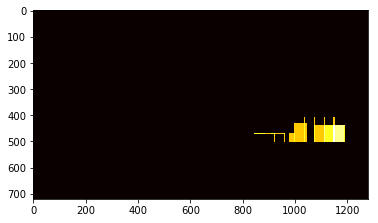

In [76]:
plt.imshow(heat_map, cmap='hot')

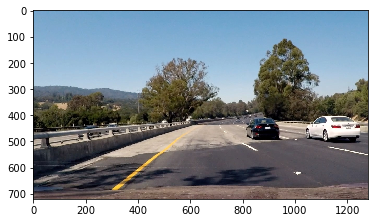

In [67]:
plt.imshow(img)

In [77]:
from scipy.ndimage.measurements import label
labels = label(heat_map)

In [78]:
labels

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 3)

(3, 'cars found')


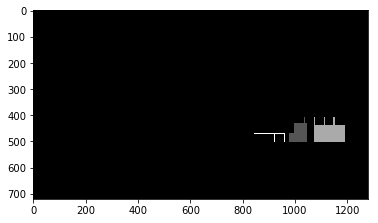

In [79]:
print(labels[1], 'cars found')
plt.imshow(labels[0], cmap='gray')

In [80]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

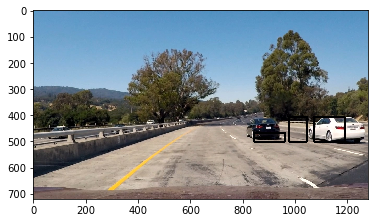

In [81]:
plt.imshow(draw_labeled_bboxes(np.copy(img), labels))

array([[[245, 235, 226],
        [242, 238, 235],
        [193, 206, 215],
        ..., 
        [ 11,  36,  58],
        [ 16,  38,  59],
        [ 28,  49,  70]],

       [[242, 238, 235],
        [188, 193, 196],
        [139, 158, 173],
        ..., 
        [ 74, 108, 135],
        [ 47,  77, 105],
        [  4,  34,  60]],

       [[190, 203, 212],
        [135, 157, 171],
        [118, 153, 181],
        ..., 
        [ 96, 144, 182],
        [ 91, 136, 175],
        [ 52,  97, 136]],

       ..., 
       [[142, 131, 129],
        [132, 121, 117],
        [114, 100,  97],
        ..., 
        [ 99,  80,  74],
        [ 99,  80,  74],
        [113,  94,  88]],

       [[164, 154, 152],
        [133, 122, 118],
        [120, 106, 103],
        ..., 
        [107,  88,  82],
        [109,  90,  84],
        [111,  92,  86]],

       [[189, 179, 177],
        [135, 126, 121],
        [130, 116, 113],
        ..., 
        [ 97,  78,  72],
        [ 95,  76,  70],
        [ 73,  54,